### Chicago Crime Classification

#### Importing Libraries & Loading in Data

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
raw_df = pd.read_csv('Chicago_Crime_Data_Cleaned.csv',index_col=['ID','Case Number'])

#### Creating Classes using Primary Type

In [3]:
raw_df['Primary Type'].value_counts()

THEFT                                546150
BATTERY                              513616
CRIMINAL DAMAGE                      319837
NARCOTICS                            298864
OTHER OFFENSE                        172726
ASSAULT                              171259
BURGLARY                             145062
MOTOR VEHICLE THEFT                  141303
ROBBERY                               99790
CRIMINAL TRESPASS                     85681
DECEPTIVE PRACTICE                    80673
PROSTITUTION                          36056
WEAPONS VIOLATION                     25074
OFFENSE INVOLVING CHILDREN            15646
PUBLIC PEACE VIOLATION                15177
HOMICIDE                              12855
SEX OFFENSE                           11318
CRIM SEXUAL ASSAULT                    8817
LIQUOR LAW VIOLATION                   6991
GAMBLING                               5793
ARSON                                  5088
KIDNAPPING                             3618
INTERFERENCE WITH PUBLIC OFFICER

Text(0, 0.5, 'Percentage')

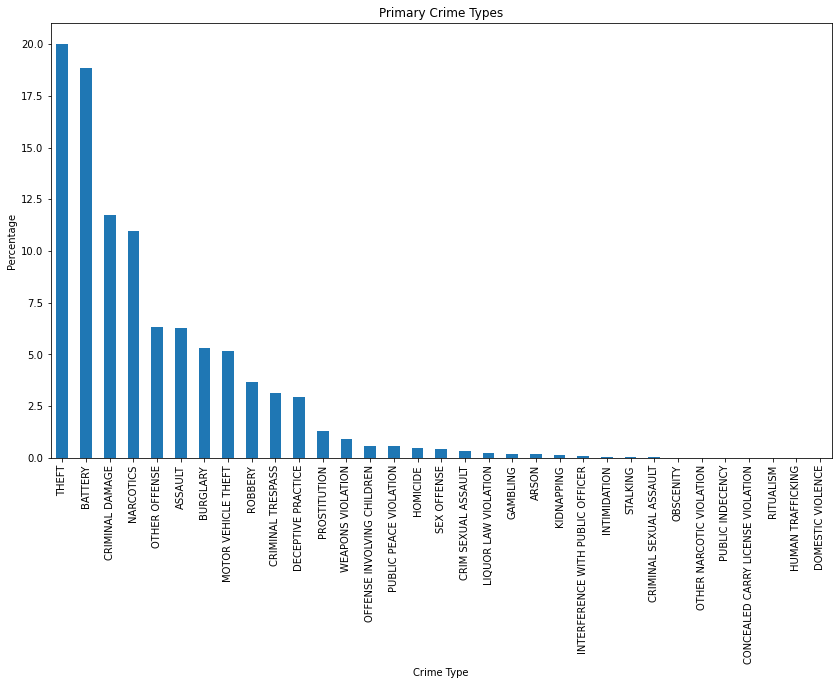

In [4]:
ax = (raw_df['Primary Type'].value_counts(normalize=True)*100).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Primary Crime Types")
ax.set_xlabel("Crime Type")
ax.set_ylabel("Percentage")

In [5]:
df = raw_df.copy()

def categorize_crimes(crime_type):
    person_offense_crimes = ['ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'HOMICIDE', 'ROBBERY', 'KIDNAPPING', 'STALKING']
    property_offense_crimes = ['THEFT', 'CRIMINAL DAMAGE', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'ARSON', 'CRIMINAL TRESPASS']
    public_safety_crimes = ['DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION', 'CONCEALED CARRY LICENSE VIOLATION',
                            'INTERFERENCE WITH PUBLIC OFFICER', 'PUBLIC PEACE VIOLATION', 'LIQUOR LAW VIOLATION', 'INTIMIDATION',
                            'GAMBLING', 'OBSCENITY', 'HUMAN TRAFFICKING', 'RITUALISM', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'OTHER OFFENSE']

    if crime_type in person_offense_crimes:
        return 'Person Offenses'
    elif crime_type in property_offense_crimes:
        return 'Property Offenses'
    elif crime_type in public_safety_crimes:
        return 'Offenses Affecting Public Health, Safety, and Decency'
    else:
        return 'Other'

df['crime_category'] = df['Primary Type'].apply(categorize_crimes)

In [6]:
df['crime_category'].value_counts(normalize=True)*100

Property Offenses                                        45.563106
Other                                                    31.436216
Offenses Affecting Public Health, Safety, and Decency    12.391849
Person Offenses                                          10.608830
Name: crime_category, dtype: float64

Text(0, 0.5, 'Percentage')

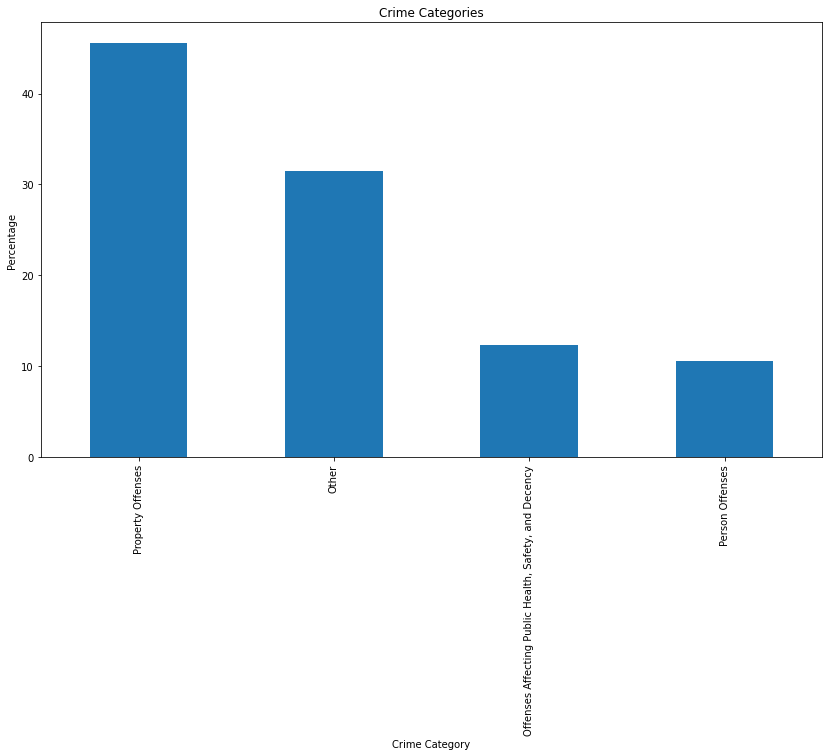

In [7]:
ax = (df['crime_category'].value_counts(normalize=True)*100).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Crime Categories")
ax.set_xlabel("Crime Category")
ax.set_ylabel("Percentage")

#### Cleaning & Feature Engineering

In [8]:
df.columns

Index(['Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Year', 'Updated On', 'Latitude', 'Longitude', 'Location',
       'Historical Wards 2003-2015', 'Zip Codes', 'Community Areas',
       'Census Tracts', 'Wards', 'Boundaries - ZIP Codes', 'Police Districts',
       'Police Beats', 'Primary Type Grouping', 'crime_category'],
      dtype='object')

In [9]:
df[['Date', 'Block','Description',
       'Location Description','Arrest', 'Domestic', 'Beat', 'District',
       'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']].isnull().sum()

Date                        0
Block                       0
Description                 0
Location Description      536
Arrest                      0
Domestic                    0
Beat                        0
District                    4
FBI Code                    0
X Coordinate            27015
Y Coordinate            27015
Year                        0
Updated On                  0
Latitude                27015
Longitude               27015
Location                27015
dtype: int64

In [10]:
'''
Removing blank rows from X, Y, Lat, Long and Location since they seem to overlap
Removing blank rows from location description and district
We will ignore the nulls in other columns because they aren't columns of interest anyhow
'''
df_clean = df[df['X Coordinate'].notnull()]
df_clean = df_clean[df_clean['Location Description'].notnull()]
df_clean = df_clean[df_clean['District'].notnull()]
df_clean.isnull().sum()

Date                               0
Block                              0
IUCR                               0
Primary Type                       0
Description                        0
Location Description               0
Arrest                             0
Domestic                           0
Beat                               0
District                           0
Ward                          605486
Community Area                603325
FBI Code                           0
X Coordinate                       0
Y Coordinate                       0
Year                               0
Updated On                         0
Latitude                           0
Longitude                          0
Location                           0
Historical Wards 2003-2015      7843
Zip Codes                          0
Community Areas                 6943
Census Tracts                   5927
Wards                           6893
Boundaries - ZIP Codes          6927
Police Districts                6509
P

In [11]:
#Ensuring the model doesn't treat codes as continuous values
df_clean['District'] = df_clean['District'].astype('category')
df_clean['Beat'] = df_clean['Beat'].astype('category')
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

In [12]:
#Extracting date parts to create new features
df_clean['month'] = df_clean['Date'].dt.month
df_clean['year'] = df_clean['Date'].dt.year
df_clean['month'] = df_clean['Date'].dt.month
df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek
df_clean['hour'] = df_clean['Date'].dt.hour

#Creating a season feature by mapping months to seasons
df_clean['season'] = df_clean['month'].apply(lambda x: 'spring' 
                                            if 3 <= x <= 5 
                                            else ('summer' if 6 <= x <= 8 
                                            else ('fall' if 9 <= x <= 11 
                                            else 'winter')))

df_clean['season'] = df_clean['season'].astype('category')

In [22]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/Emi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Emi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Emi/nltk_data...


True

In [24]:
df_resetindex = df_clean.reset_index()

descriptions = df_resetindex[['Description', 'Location Description']]

def process_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize words
    words = nltk.word_tokenize(text)
    
    # Remove stop words and apply lemmatization
    processed_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    
    # Join processed words back into a sentence
    processed_text = ' '.join(processed_words)
    
    return processed_text

df_resetindex['processed_description'] = df_resetindex['Description'].apply(process_text)
df_resetindex['processed_location_description'] = df_resetindex['Location Description'].apply(process_text)

'''
vectorizer = TfidfVectorizer()
X_description = vectorizer.fit_transform(df_resetindex['processed_description'])

# Create a new dataframe with the TF-IDF features
df_description_features = pd.DataFrame(X_description.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the new features with the original dataframe
df_combined = pd.concat([df_resetindex, df_description_features], axis=1)
'''

KeyboardInterrupt: 

#### Selecting Features & Target and Splitting Data

In [ ]:
X = df_combined[['Arrest', 'Domestic', 'Beat', 'District',
              #'X Coordinate', 'Y Coordinate',  --- will add these location based features in later
              #'Latitude', 'Longitude', 'Location',
              'month','year', 'day_of_week', 'hour', 'season']]

y = df_combined['crime_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#Encoding Binary Features
le = LabelEncoder()
X_train_encoded = X_train.copy()
X_train_encoded['Arrest'] = le.fit_transform(X_train['Arrest'])
X_train_encoded['Domestic'] = le.fit_transform(X_train['Domestic'])

#Encoding Categorical Features
X_train_encoded['season'] = le.fit_transform(X_train['season'])
X_train_encoded['season'] = X_train_encoded['season'].astype('category')
X_train_encoded.head()

In [ ]:
X_train_encoded.columns